In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score, classification_report
import lime.lime_text
import re
import tkinter as tk
from tkinter import scrolledtext, messagebox, Label
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Load and inspect the dataset
file_path = 'Phishing_Email.csv'
data = pd.read_csv(file_path)
data.rename(columns={'Email Text': 'text', 'Email Type': 'label'}, inplace=True)

# Preprocess the data
data['text'] = data['text'].str.lower().str.replace(r'<[^<>]*>', '', regex=True).str.replace(r'[^a-z\s]', '', regex=True)
data['text'] = data['text'].fillna('')

# Feature Engineering
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(data['text'])
y = data['label'].apply(lambda x: 1 if x == 'Phishing Email' else 0)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Initialize and train the SVM model with updated hyperparameters
svm_model = SVC(probability=True, C=10, kernel='rbf')
svm_model.fit(X_train, y_train)

# Initialize LIME
explainer = lime.lime_text.LimeTextExplainer(class_names=['Safe Email', 'Phishing Email'])

In [6]:
# Function to check for phishing using the SVM model and LIME explanation
def check_email_for_phishing(email_body, result_label, lime_canvas, warning_label, probability_canvas):
    if not email_body:
        result_label.config(text="No email content provided.")
        warning_label.config(text="")
        return

    # Preprocess the email text
    email_body = re.sub(r'<[^<>]*>', '', email_body.lower())
    email_body = re.sub(r'[^a-z\s]', '', email_body)

    # Transform the text and predict
    transformed_text = vectorizer.transform([email_body])
    svm_prediction = svm_model.predict(transformed_text)[0]
    probabilities = svm_model.predict_proba(transformed_text)[0]

    # Display the prediction
    result_text = f"SVM Prediction: {'Phishing Email' if svm_prediction == 1 else 'Safe Email'}"
    result_label.config(text=result_text)

    # Clear previous canvas content for the LIME explanation and probability bar if any
    for widget in lime_canvas.winfo_children():
        widget.destroy()
    for widget in probability_canvas.winfo_children():
        widget.destroy()

    # Plot probability bar graph
    fig, ax = plt.subplots(figsize=(10, 2.5))  # Increase height for better spacing
    ax.barh(['Safe Email', 'Phishing Email'], probabilities, color=['green', 'red'])
    ax.set_xlim(0, 1)
    ax.set_xlabel('Probability')

    # Display probability values next to each bar
    for i, v in enumerate(probabilities):
        ax.text(v - 0.05 if v > 0.1 else v + 0.02, i, f"{v:.2f}", color='white' if v > 0.1 else 'black', va='center')

    # Display probability bar graph in the GUI
    prob_bar = FigureCanvasTkAgg(fig, master=probability_canvas)
    prob_bar.draw()
    prob_bar.get_tk_widget().pack()

    # Plot and display LIME explanation in lime_canvas
    exp = explainer.explain_instance(email_body, predict_proba_wrapper, num_features=10)
    fig_lime = exp.as_pyplot_figure()
    canvas = FigureCanvasTkAgg(fig_lime, master=lime_canvas)
    canvas.draw()
    canvas.get_tk_widget().pack()

    # Display a prominent warning message if predicted as phishing
    if svm_prediction == 1:
        warning_label.config(
            text="⚠️ Warning: This email is predicted as a phishing email. Please verify the sender before taking any action.",
            fg="red",
            font=("Arial", 14, "bold")
        )
    else:
        warning_label.config(
            text="The email is predicted as safe. Always verify the sender's authenticity.",
            fg="green",
            font=("Arial", 12)
        )

In [7]:
# Wrapper function for LIME
def predict_proba_wrapper(texts):
    transformed_texts = vectorizer.transform(texts)
    return svm_model.predict_proba(transformed_texts)

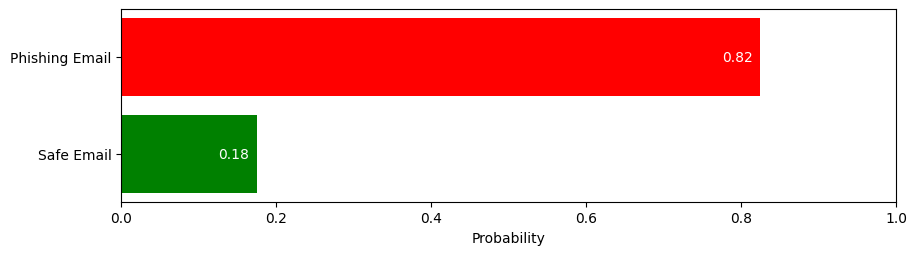

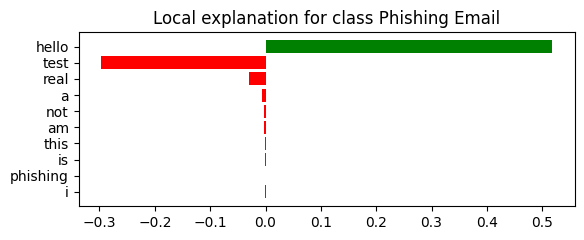

In [8]:
# Function to display the GUI
def get_user_input():
    # Initialize Tkinter window
    root = tk.Tk()
    root.title("Phishing Email Detection")
    root.geometry("1080x900")

    # UI Elements
    tk.Label(root, text="Please enter the email body:", font=("Arial", 14)).pack(pady=10)
    text_area = scrolledtext.ScrolledText(root, wrap=tk.WORD, font=("Arial", 12), height=10, width=80)
    text_area.pack(padx=10, pady=10)

    # Result label
    result_label = tk.Label(root, text="", font=("Arial", 14), fg="blue")
    result_label.pack(pady=10)

    # Warning message label
    warning_label = tk.Label(root, text="", font=("Arial", 14))
    warning_label.pack(pady=10)

    # Probability bar graph area
    tk.Label(root, text="Prediction Probabilities:", font=("Arial", 14)).pack(pady=5)
    probability_canvas = tk.Frame(root)
    probability_canvas.pack()

    # LIME explanation plot area
    tk.Label(root, text="LIME Explanation:", font=("Arial", 14)).pack(pady=5)
    lime_canvas = tk.Frame(root)
    lime_canvas.pack()

    # Function to process input
    def process_input():
        email_body = text_area.get("1.0", tk.END).strip()
        check_email_for_phishing(email_body, result_label, lime_canvas, warning_label, probability_canvas)

    tk.Button(root, text="Check for Phishing", font=("Arial", 12), command=process_input).pack(pady=20)

    # Start Tkinter main loop
    root.mainloop()

# Run the GUI application
get_user_input()

In [9]:
y_pred = svm_model.predict(X_test)
errors = X_test[(y_pred != y_test)]
print(errors)


AttributeError: 'Series' object has no attribute 'nonzero'